In [1]:
# Necessary imports

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bs4
import time
import matplotlib.pyplot as plt
from env import github_token, github_username

import acquire
from prepare import prep_data, remove_stopwords, split

import nltk
import unicodedata
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

### Acquire the data

In [2]:
# This code doesn't need to be run after the initial data acquisition as it takes some time

# data = acquire.scrape_github_data()

#### Successfully acquired urls and turned into a df

In [3]:
# This code doesn't need to be run after the initial data acquisition

# df = pd.DataFrame(data)

In [4]:
# This code doesn't need to be run after the csv has been acquired
# Write df to csv file

# df.to_csv('repos.csv')

### *Start here*

In [5]:
# Convert back to a df and specify the index

data_df = pd.read_csv ('repos.csv', index_col=0)

In [6]:
# Checking out the df

data_df.head()

,repo,language,readme_contents
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...
3,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...
4,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...


In [7]:
# Taking a closer look at the columns of my df

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             407 non-null    object
 1   language         337 non-null    object
 2   readme_contents  403 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


## Prepare

#### Checking out nulls in the 'language' column

In [8]:
# I see that I have 70 nulls values

data_df.language.value_counts(dropna=False)

JavaScript          83
NaN                 70
Java                36
C++                 30
Python              28
HTML                27
C                   24
C#                  17
TypeScript          14
Go                  11
Shell                8
Jupyter Notebook     8
Swift                6
CSS                  5
PowerShell           4
Ruby                 4
Kotlin               4
Objective-C          4
TeX                  3
Dart                 2
Scala                2
CoffeeScript         2
PHP                  2
Ada                  1
Clojure              1
Erlang               1
Groovy               1
PostScript           1
Objective-C++        1
Nunjucks             1
Assembly             1
Handlebars           1
Rust                 1
Nix                  1
Makefile             1
MATLAB               1
Name: language, dtype: int64

#### Made the decision to drop all of the 'language' nulls, taking my data from 407 observations to 337 observations

In [9]:
# Dropping nulls

data_df = data_df.dropna()

In [10]:
# Checking out the df shape

data_df.shape

(333, 3)

In [11]:
# Dropping any languages that have less than 10 occurances

data_df = data_df.groupby('language').filter(lambda x : len(x)>10)

In [12]:
# Confirming the new look of the 'language' column

data_df.language.value_counts(dropna=False)

JavaScript    82
Java          36
C++           28
Python        28
HTML          27
C             23
C#            17
TypeScript    14
Go            11
Name: language, dtype: int64

In [13]:
# Checking out the df shape

data_df.shape

(266, 3)

In [14]:
# Get a visual of my df

df = prep_data(data_df, 'readme_contents').reset_index().drop(columns='index')
df.head()

,repo,language,readme_contents,clean_lemmatized
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movie application project building single page...
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel several guide kernel developer us...
2,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...
3,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...
4,yeasy/docker_practice,Go,# Docker — 从入门到实践\n\n[![](https://img.shields....,docker httpsimgshieldsiogithubstarsyeasydocker...


#### After prepping my data, I have dropped from an initial 407 observatins to 266 observations

- I dropped my null values: 70 in 'language" and 4 in 'readme_contents'
- I dropped any language that had less than 10 occurances
- I used my prepare.py to clean, tokenize, and lemmatize the 'readme_contents' column

### Explore

In [15]:
# Create a dictionary to hold subsets by language

lang_dict = {}

for lang in df.language:
    lang_dict[f'{lang}'] = df[df.language == lang]

In [16]:
# Checking my dictionary keys

lang_dict.keys()

dict_keys(['JavaScript', 'C', 'HTML', 'Go', 'TypeScript', 'C++', 'C#', 'Python', 'Java'])

In [17]:
# Create strings of cleaned and lemmatized words by language

js_words = ' '.join(lang_dict['JavaScript'].clean_lemmatized)
c_words = ' '.join(lang_dict['C'].clean_lemmatized)
html_words = ' '.join(lang_dict['HTML'].clean_lemmatized)
go_words = ' '.join(lang_dict['Go'].clean_lemmatized)
typescript_words = ' '.join(lang_dict['TypeScript'].clean_lemmatized)
c_plus_words = ' '.join(lang_dict['C++'].clean_lemmatized)
c_sharp_words = ' '.join(lang_dict['C#'].clean_lemmatized)
python_words = ' '.join(lang_dict['Python'].clean_lemmatized)
java_words = ' '.join(lang_dict['Java'].clean_lemmatized)

In [114]:
# Create df of top 20 words in each language subset
top_20_words = pd.concat([pd.Series(js_words.split()).value_counts().head(20), pd.Series(html_words.split()).value_counts().head(20)], axis=1)

# Rename columns in initial df
top_20_words.columns = ['js_words', 'html_words']

# Add columns of top 20 words for each language
top_20_words['python_words'] = pd.Series(python_words.split()).value_counts().head(20)
top_20_words['java_words'] = pd.Series(java_words.split()).value_counts().head(20)
top_20_words['c_words'] = pd.Series(c_words.split()).value_counts().head(20)
top_20_words['c_plus_words'] = pd.Series(c_plus_words.split()).value_counts().head(20)
top_20_words['c_sharp_words'] = pd.Series(c_sharp_words.split()).value_counts().head(20)
top_20_words['go_words'] = pd.Series(go_words.split()).value_counts().head(20)
top_20_words['typescript_words'] = pd.Series(typescript_words.split()).value_counts().head(20)

In [115]:
# Checking out the df

top_20_words.head()

,js_words,html_words,python_words,java_words,c_words,c_plus_words,c_sharp_words,go_words,typescript_words
component,292.0,NaN,NaN,NaN,NaN,NaN,41.0,NaN,22.0
detail,213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
web,211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serverless,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
server,162.0,NaN,NaN,77.0,NaN,NaN,NaN,NaN,30.0


In [125]:
# Make bigrams using nltk to get a better feel for the data

js_bigrams = pd.Series(nltk.ngrams(js_words.split(), 2)).value_counts().head(10)
java_bigrams = pd.Series(nltk.ngrams(java_words.split(), 2)).value_counts().head(10)
python_bigrams = pd.Series(nltk.ngrams(python_words.split(), 2)).value_counts().head(10)
html_bigrams = pd.Series(nltk.ngrams(html_words.split(), 2)).value_counts().head(10)

In [124]:
js_bigrams

(blog, post)               95
(detail, detail)           90
(serverless, component)    52
(starter, kit)             46
(web, component)           39
(apollo, universal)        36
(createdat, updatedat)     36
(universal, starter)       36
(ui5, web)                 35
(open, source)             34
dtype: int64

In [126]:
java_bigrams

(quickstart, demonstrates)                  51
(intermediate, _none_)                      38
(dependency, groupidcomkumuluzeegroupid)    28
(test, ok)                                  28
(beginner, _none_)                          27
(command, line)                             21
(following, command)                        20
(wildfly, server)                           19
(spring, boot)                              19
(actual, value)                             16
dtype: int64

In [127]:
python_bigrams

(cumulative, number)              59
(number, point)                   40
(number, question)                33
(span, stylecolorgreysospan)      29
(span, stylecolororangehnspan)    28
(question, span)                  27
(open, source)                    23
(time, series)                    21
(topic, span)                     21
(google, cloud)                   19
dtype: int64

In [128]:
html_bigrams

(face, recognition)          101
(3d, face)                    43
(face, detection)             31
(deep, face)                  27
(face, alignment)             22
(adversarial, network)        21
(face, reconstruction)        21
(docker, image)               18
(implementation, status)      17
(generative, adversarial)     17
dtype: int64

In [20]:
# Create a column that counts the number of repos a word appears in.

top_20_words['languages_with_word'] = top_20_words.loc[:,'js_words':'typescript_words'].notnull().sum(axis=1)

top_20_words.sort_values('languages_with_word', ascending=False).head(10)

,js_words,html_words,python_words,java,c_words,c_plus_words,c_sharp_words,go_words,typescript_words,languages_with_word
use,256.0,62.0,76.0,113.0,46.0,59.0,40.0,17.0,30.0,9
project,291.0,57.0,NaN,78.0,37.0,63.0,58.0,18.0,NaN,7
using,213.0,NaN,71.0,84.0,41.0,67.0,56.0,31.0,NaN,7
file,208.0,107.0,64.0,99.0,82.0,68.0,NaN,18.0,NaN,7
&#9;,3247.0,NaN,71.0,415.0,102.0,146.0,NaN,48.0,NaN,6
build,190.0,NaN,NaN,120.0,86.0,53.0,NaN,22.0,42.0,6
run,160.0,60.0,NaN,103.0,50.0,NaN,NaN,14.0,38.0,6
install,138.0,62.0,76.0,NaN,51.0,NaN,NaN,NaN,36.0,5
code,161.0,NaN,79.0,73.0,NaN,NaN,40.0,NaN,26.0,5
technology,142.0,63.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,3


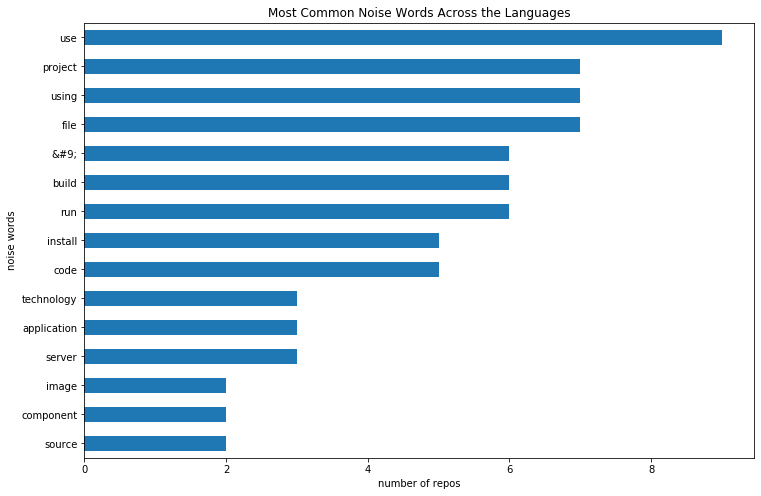

In [111]:
# Plot the words that appear in the most repos to find noise that can be removed
plt.figure(figsize=(12, 8))

top_20_words.languages_with_word.sort_values(ascending=False).head(15).plot(kind='barh')
plt.gca().invert_yaxis()

plt.ylabel('noise words')
plt.xlabel('number of repos')
plt.title('Most Common Noise Words Across the Languages')
plt.show()

### Viz Takeaway
- A lot of pretty generic words are sprinkled in here 
- Probably not very insightful since these words appear in the majority of the languages
- These seems like good candidates to drop

In [22]:
# Isolating the 10 most common 'noise' words

top_20_words.sort_values('languages_with_word', ascending=False).index[:10].tolist()

['use',
 'project',
 'using',
 'file',
 '&#9;',
 'build',
 'run',
 'install',
 'code',
 'technology']

In [23]:
# Grouping the 10 noisiest words together

extra_words=['use','project','using','file','&#9;','build','install','run','application','code']

In [24]:
# Removing the 10 noisiest words from the df

df = remove_stopwords(df, 'clean_lemmatized', extra_words = extra_words)

In [25]:
df.head()

,repo,language,readme_contents,clean_lemmatized,clean_clean_lemmatized
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movie application project building single page...,movie building single page movie spa allow use...
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel several guide kernel developer us...,linux kernel several guide kernel developer us...
2,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...
3,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...
4,yeasy/docker_practice,Go,# Docker — 从入门到实践\n\n[![](https://img.shields....,docker httpsimgshieldsiogithubstarsyeasydocker...,docker httpsimgshieldsiogithubstarsyeasydocker...


In [26]:
# Create a dictionary to hold subsets by language

lang_dict2 = {}

for lang in df.language:
    lang_dict2[f'{lang}'] = df[df.language == lang]

In [27]:
# Create strings of cleaned and lemmatized words by language

js_words = ' '.join(lang_dict2['JavaScript'].clean_clean_lemmatized)
c_words = ' '.join(lang_dict2['C'].clean_clean_lemmatized)
html_words = ' '.join(lang_dict2['HTML'].clean_clean_lemmatized)
go_words = ' '.join(lang_dict2['Go'].clean_clean_lemmatized)
typescript_words = ' '.join(lang_dict2['TypeScript'].clean_clean_lemmatized)
c_plus_words = ' '.join(lang_dict2['C++'].clean_clean_lemmatized)
c_sharp_words = ' '.join(lang_dict2['C#'].clean_clean_lemmatized)
python_words = ' '.join(lang_dict2['Python'].clean_clean_lemmatized)
java_words = ' '.join(lang_dict2['Java'].clean_clean_lemmatized)

In [117]:
# Create df of top 20 words in each language subset
top_20_words2 = pd.concat([pd.Series(js_words.split()).value_counts().head(20), pd.Series(html_words.split()).value_counts().head(20)], axis=1)

# Rename columns in initial df.
top_20_words2.columns = ['js_words', 'html_words']

# Add columns of top 20 words for each language
top_20_words2['python_words'] = pd.Series(python_words.split()).value_counts().head(20)
top_20_words2['java_words'] = pd.Series(java_words.split()).value_counts().head(20)
top_20_words2['c_words'] = pd.Series(c_words.split()).value_counts().head(20)
top_20_words2['c_plus_words'] = pd.Series(c_plus_words.split()).value_counts().head(20)
top_20_words2['c_sharp_words'] = pd.Series(c_sharp_words.split()).value_counts().head(20)
top_20_words2['go_words'] = pd.Series(go_words.split()).value_counts().head(20)
top_20_words2['typescript_words'] = pd.Series(typescript_words.split()).value_counts().head(20)

In [118]:
# Create a column that counts the number of repos a word appears in

top_20_words2['languages_with_word'] = top_20_words2.loc[:,'js_words':'typescript_words'].notnull().sum(axis=1)

top_20_words2.sort_values('languages_with_word', ascending=False).head(10)

,js_words,html_words,python_words,java_words,c_words,c_plus_words,c_sharp_words,go_words,typescript_words,languages_with_word
1,131.0,NaN,65.0,NaN,30.0,102.0,NaN,25.0,NaN,5
data,120.0,NaN,122.0,NaN,NaN,NaN,36.0,14.0,NaN,4
component,292.0,NaN,NaN,NaN,NaN,NaN,41.0,NaN,22.0,3
version,NaN,50.0,NaN,85.0,34.0,NaN,NaN,NaN,NaN,3
server,162.0,NaN,NaN,77.0,NaN,NaN,NaN,NaN,30.0,3
technology,142.0,63.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,3
support,124.0,NaN,NaN,81.0,32.0,NaN,NaN,NaN,NaN,3
image,NaN,74.0,NaN,NaN,NaN,NaN,57.0,NaN,NaN,2
html,116.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
need,125.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,2


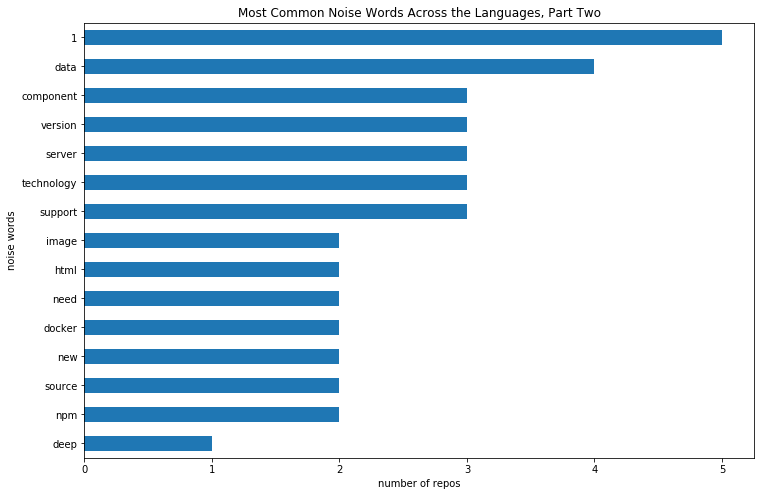

In [112]:
# Plot the words that appear in the most repos to find noise that can be removed

plt.figure(figsize=(12, 8))

top_20_words2.languages_with_word.sort_values(ascending=False).head(15).plot(kind='barh')
plt.gca().invert_yaxis()

plt.ylabel('noise words')
plt.xlabel('number of repos')
plt.title('Most Common Noise Words Across the Languages, Part Two')
plt.show()

In [31]:
# Remove a few more words that appear to be noise and move on

extra_words = ['1', 'data', 'make', 'version', 'server', 'technology', 'support']
df = remove_stopwords(df, 'clean_lemmatized', extra_words = extra_words)

#### Prep Takeaways
- Removed many more words that were noisy: too generic too helpful predictors 

## Modeling

In [32]:
# Split my data

train, validate, test = split(df, 'language')
train.head()

,repo,language,readme_contents,clean_lemmatized,clean_clean_lemmatized
205,googlevr/seurat-unity-plugin,C#,# Importing Seurat Meshes Into Unity\n\nSeurat...,importing seurat mesh unity seurat scene simpl...,importing seurat mesh unity seurat scene simpl...
128,shuaishaui/springboot-technology,Java,# springboot-technology\nspringboot整合自己到目前学习到的...,springboottechnology springboot,springboottechnology springboot
208,kalaspuff/tomodachi,Python,``tomodachi`` - a lightweight microservices li...,tomodachi lightweight microservices library py...,tomodachi lightweight microservices library py...
75,dolevf/Damn-Vulnerable-GraphQL-Application,JavaScript,# Damn Vulnerable GraphQL Application\nDamn Vu...,damn vulnerable graphql application damn vulne...,damn vulnerable graphql application damn vulne...
214,tyrchen/book_next,JavaScript,---\ntitle: '程序君的公众号'\nauthor:\n - 程序君\nkeywo...,title author keywords readme,title author keywords readme


In [33]:
# Visualize my split data

print(train.shape, validate.shape, test.shape)

(148, 5) (64, 5) (54, 5)


In [34]:
# Set up my X variables

X_train = train.clean_clean_lemmatized
X_validate = validate.clean_clean_lemmatized
X_test = test.clean_clean_lemmatized

In [35]:
# Set up my y variables

y_train = train.language
y_validate = validate.language
y_test = test.language

### Vectorize my data

In [36]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classification models
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

### Create my baseline accuracy

In [37]:
# My baseline accuracy is 31% because JavaScript, the mode value, represents 31% of the language values in the df

((df.language.value_counts().head(1).values / df.shape[0])[0])

0.3082706766917293

### 1. Logistic Regression Model

In [38]:
# Running a LR model on my vectorized dataset
lm = LogisticRegression()

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression()

In [39]:
# Showing the actual values

train_eval = pd.DataFrame(dict(actual=y_train))
validate_eval = pd.DataFrame(dict(actual=y_validate))
test_eval = pd.DataFrame(dict(actual=y_test))

In [41]:
# Use the trained model to predict y given those vectorized inputs of X

train_eval['predicted'] = lm.predict(X_train_vectorized)
validate_eval["predicted"] = lm.predict(X_validate_vectorized)
test_eval['predicted'] = lm.predict(X_test_vectorized)

In [42]:
# Getting a preview of actual vs predicted

train_eval.head()

,actual,predicted
205,C#,JavaScript
128,Java,Java
208,Python,JavaScript
75,JavaScript,JavaScript
214,JavaScript,JavaScript


In [43]:
# Train Accuracy

(train_eval.actual == train_eval.predicted).mean()

0.5540540540540541

In [44]:
# Out of sample accuracy

(validate_eval.actual == validate_eval.predicted).mean()

0.296875

In [45]:
# Classification report on train

from sklearn.metrics import classification_report
print(classification_report(train_eval.actual, train_eval.predicted))

              precision    recall  f1-score   support

           C       1.00      0.23      0.38        13
          C#       0.00      0.00      0.00        10
         C++       1.00      0.40      0.57        15
          Go       0.00      0.00      0.00         6
        HTML       1.00      0.27      0.42        15
        Java       1.00      0.95      0.97        20
  JavaScript       0.41      1.00      0.58        46
      Python       1.00      0.27      0.42        15
  TypeScript       0.00      0.00      0.00         8

    accuracy                           0.55       148
   macro avg       0.60      0.35      0.37       148
weighted avg       0.65      0.55      0.49       148



In [72]:
# Classification report on validate

from sklearn.metrics import classification_report
print(classification_report(validate_eval.actual, validate_eval.predicted))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
          C#       0.00      0.00      0.00         4
         C++       0.00      0.00      0.00         7
          Go       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         7
        Java       0.00      0.00      0.00         9
  JavaScript       0.30      1.00      0.46        19
      Python       0.00      0.00      0.00         7
  TypeScript       0.00      0.00      0.00         3

    accuracy                           0.30        64
   macro avg       0.03      0.11      0.05        64
weighted avg       0.09      0.30      0.14        64



### Takeaway
- Logistic Regression model performed pretty weak on train data
- The same model performed even worse on validate data
- The model was overfit, but it did improve on the baseline

### 2. Decision Tree w depth=3

In [46]:
# modeling and evaluating
from sklearn.tree import DecisionTreeClassifier

# Create the model

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model

clf.fit(X_train_vectorized, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

#### Train

In [47]:
# Use the model to get accuracy score for train dataset

clf.score(X_train_vectorized, y_train)

In [47]:
print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_train_vectorized, y_train) * 100)}%')

Accuracy of Decision Tree classifier on training set: 43%


#### Validate

In [48]:
# Use the model to get accuracy score for Validate dataset

clf.score(X_validate_vectorized, y_validate)

In [48]:
print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_validate_vectorized, y_validate) * 100)}%')

Accuracy of Decision Tree classifier on training set: 38%


### Takeaway
- Decision Tree had low accuracy on train data
- Even lower accuracy on validate
- The model was also overfit, but it outperformed the baseline

In [49]:
# Create df to dig into accuracy by language.

dt_train_eval = pd.DataFrame(dict(actual=y_train))
dt_validate_eval = pd.DataFrame(dict(actual=y_validate))
dt_test_eval = pd.DataFrame(dict(actual=y_test))

In [50]:
# Use the trained dt model to predict y given those vectorized inputs of X.

dt_train_eval['predicted'] = clf.predict(X_train_vectorized)
dt_validate_eval["predicted"] =clf.predict(X_validate_vectorized)
dt_test_eval['predicted'] = clf.predict(X_test_vectorized)

In [51]:
df.language.value_counts()

JavaScript    82
Java          36
C++           28
Python        28
HTML          27
C             23
C#            17
TypeScript    14
Go            11
Name: language, dtype: int64

##### Dig into JavaScript Accuracy

In [52]:
js_dt_eval = dt_train_eval[dt_train_eval.actual == 'JavaScript']

In [53]:
(js_dt_eval.actual == js_dt_eval.predicted).mean()

1.0

##### Dig into Python Accuracy

In [54]:
python_dt_eval = dt_train_eval[dt_train_eval.actual == 'Python']

In [55]:
(python_dt_eval.actual == python_dt_eval.predicted).mean()

0.4

##### Dig into Java Accuracy

In [56]:
j_dt_eval = dt_train_eval[dt_train_eval.actual == 'Java']

In [57]:
(j_dt_eval.actual == j_dt_eval.predicted).mean()

0.45

##### Dig into TypeScript Accuracy

In [107]:
t_dt_eval = dt_train_eval[dt_train_eval.actual == 'TypeScript']

In [108]:
(t_dt_eval.actual == t_dt_eval.predicted).mean()

0.0

##### Dig into Go Accuracy

In [58]:
g_dt_eval = dt_train_eval[dt_train_eval.actual == 'Go']
(g_dt_eval.actual == g_dt_eval.predicted).mean()

0.0

#### Takeaway
- The lesser-occuring languages are dragging the accuracy down
- Maybe drop some of the languages that occur less
- Maybe try to balance the dataset

### Let's Try Balancing the Dataset

In [59]:
# Create SMOTE object

sm = SMOTE(random_state=123)

In [62]:
# Fit the SMOTE object and resample

X_train_sm, y_train_sm = sm.fit_resample(X_train_vectorized, y_train)

In [63]:
print(f'''Shape of X before SMOTE: {X_train_vectorized.shape}
Shape of X after SMOTE: {X_train_sm.shape}''')

Shape of X before SMOTE: (148, 16620)
Shape of X after SMOTE: (414, 16620)


In [64]:
# The train dataset is perfectly balanced now

print('\nBalance of positive and negative classes (%):')
y_train_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


Java          11.111111
C++           11.111111
C             11.111111
JavaScript    11.111111
Go            11.111111
C#            11.111111
HTML          11.111111
TypeScript    11.111111
Python        11.111111
Name: language, dtype: float64

#### Train a DT Model on Oversampled Train Dataset

In [68]:
# Create the model

clf_sm = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model

clf_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [69]:
# Use the model to get accuracy score for train dataset

clf_sm.score(X_train_sm, y_train_sm)

0.3647342995169082

In [70]:
print(f'Accuracy of Decision Tree classifier after SMOTE on training set: {round(clf_sm.score(X_train_sm, y_train_sm) * 100)}%')

Accuracy of Decision Tree classifier after SMOTE on training set: 36%


#### Use New DT Model Trained on Oversampled Data with Validate Dataset

In [71]:
# Use the model to get accuracy score for Validate dataset

print(f'Accuracy of Decision Tree classifier After SMOTE on validate dataset: {round(clf_sm.score(X_validate_vectorized, y_validate) * 100)}%')

Accuracy of Decision Tree classifier After SMOTE on validate dataset: 14%


#### Takeaway
- Both train and validate accuracy were lowest yet

### What if I narrow my languages to the top 5?

In [131]:
# Isolating my top 5 languages

top_5_train = train[train.language.isin(['JavaScript', 'Java', 'Python', 'C', 'HTML'])]
top_5_val = validate[validate.language.isin(['JavaScript', 'Java', 'Python', 'C', 'HTML'])]
top_5_test = test[test.language.isin(['JavaScript', 'Java', 'Python', 'C', 'HTML'])]

In [79]:
# Check out the shape 

print(top_5_train.shape, top_5_val.shape, top_5_test.shape)

(109, 5) (47, 5) (40, 5)


In [80]:
# Create X and y

X_top_5_train = top_5_train.clean_clean_lemmatized
X_top_5_val = top_5_val.clean_clean_lemmatized
X_top_5_test = top_5_test.clean_clean_lemmatized

In [81]:
y_top_5_train = top_5_train.language
y_top_5_val = top_5_val.language
y_top_5_test = top_5_test.language

In [85]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_top_5_train)

# Use the object
X_top_5_train_vectorized = tfidf.transform(X_top_5_train)
X_top_5_val_vectorized = tfidf.transform(X_top_5_val)
X_top_5_test_vectorized = tfidf.transform(X_top_5_test)

In [88]:
# Check out the shape post-vectorizing

X_top_5_train_vectorized.shape

(109, 13049)

### Top 5 Languages Before Oversampling

In [94]:
# Create the Decision Tree model for the top 5 languages

clf5 = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model

clf5.fit(X_top_5_train_vectorized, y_top_5_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [95]:
print(f'Accuracy of Decision Tree classifier on Top 5 Languges Before SMOTE on training set: {round(clf5.score(X_top_5_train_vectorized, y_top_5_train) * 100)}%')

Accuracy of Decision Tree classifier on Top 5 Languges Before SMOTE on training set: 61%


In [96]:
print(f'Accuracy of Decision Tree classifier on Top 5 Languages Before SMOTE on validate dataset: {round(clf5.score(X_top_5_val_vectorized, y_top_5_val) * 100)}%')

Accuracy of Decision Tree classifier on Top 5 Languages Before SMOTE on validate dataset: 55%


#### Takeaway
- By limiting my languages to the top 5, I got better results on both train and validate 

### Oversampling using SMOTE

In [86]:
# Fit the SMOTE object and resample the top_5_train dataset

X_train_sm5, y_train_sm5 = sm5.fit_resample(X_top_5_train_vectorized, y_top_5_train)

In [87]:
print(X_train_sm5.shape, y_train_sm5.shape)

(230, 13049) (230,)


In [109]:
# The train dataset is perfectly balanced now

print('\nBalance of languauges (%):')
y_train_sm5.value_counts(normalize=True) * 100


Balance of languauges (%):


Java          20.0
HTML          20.0
C             20.0
JavaScript    20.0
Python        20.0
Name: language, dtype: float64

In [90]:
# Create the model for the top 5 languages; X is vectorized and oversampled

clf_sm5 = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model

clf_sm5.fit(X_train_sm5, y_train_sm5)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [91]:
# Use the model to get accuracy score for train dataset

print(f'Accuracy of Decision Tree classifier on Top 5 Languges after SMOTE on training set: {round(clf_sm5.score(X_train_sm5, y_train_sm5) * 100)}%')

Accuracy of Decision Tree classifier on Top 5 Languges after SMOTE on training set: 63%


In [92]:
# Use the model to get accuracy score for validate dataset

print(f'Accuracy of Decision Tree classifier on Top 5 Languages After SMOTE on validate dataset: {round(clf_sm5.score(X_top_5_val_vectorized, y_top_5_val) * 100)}%')

Accuracy of Decision Tree classifier on Top 5 Languages After SMOTE on validate dataset: 28%


#### Takeaway
- Decision Tree performed reasonably well on my balanced train data
- The dropoff was substantial on  balanced validate

## Test the Data
- I chose my best-performing model: Decision Tree using top 5 languages with the dataset not oversampled

In [137]:
print(f'Accuracy of Decision Tree classifier on Top 5 Languges on test set: {round(clf5.score(X_top_5_test_vectorized, y_top_5_test) * 100)}%')

Accuracy of Decision Tree classifier on Top 5 Languges on test set: 60%


### Takeaway:
- My Decision Tree Top 5 model performed better than expected at 60%
- The test model was right in line with the train and validate - both hovering between 61% and 55%
- I consider this a success although still much room for improvement

## Conclusion:
- Because the initial baseline was so low, even a weak-performing model could beat it
- Each model was overfit

## Next steps:
- As small training datasets are prone to over-fitting, I'd get a larger dataset to sample
- I'd like to work with SMOTE more and get the hang of it